In [1]:
from utils.dataset import set_b_dataset
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import librosa
import scipy
import librosa.display
from torch.utils.data import Dataset

PROJECT_DIR = '/Users/nattapolchanpaisit/Documents/GitHub/Algorithm/SC1015-PROJECT/'
data_a_path = pd.read_csv(f'{PROJECT_DIR}dataset/set_a.csv')
data_b_path = pd.read_csv(f'{PROJECT_DIR}dataset/set_b.csv')
data_a_timing = pd.read_csv(f'{PROJECT_DIR}dataset/set_a_timing.csv')

dataset = set_b_dataset(PROJECT_DIR)

## Exploratory data analysis

In [27]:
np.array(dataset.dataset)[:, 0].shape

/var/folders/mk/w2mwvrjn5sn9g2fty5rrgzd40000gn/T/ipykernel_32931/1126781425.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(dataset.dataset)[:, 0].shape


(461,)

(0.0, 30.0)

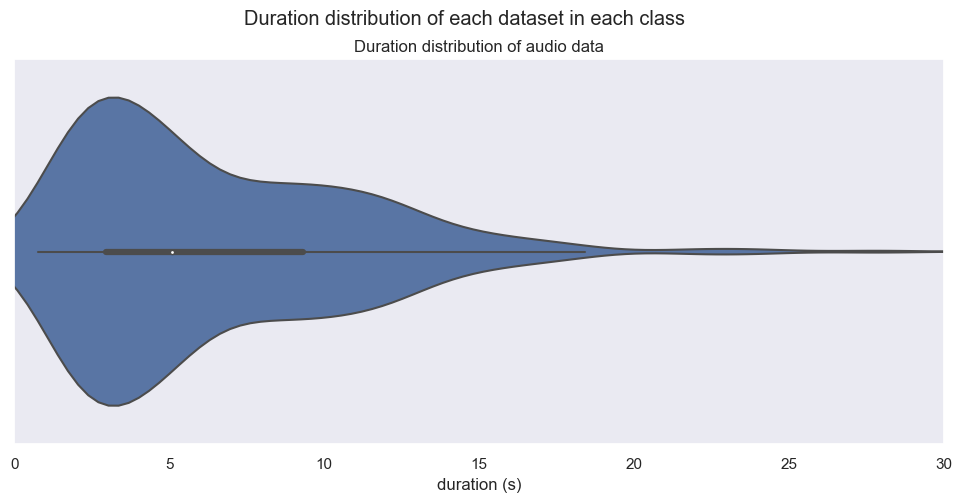

In [28]:
fig = plt.figure(figsize=(12,5))
fig.tight_layout(w_pad=3.0)
fig.suptitle('Duration distribution of each dataset in each class')
sb.set_theme(style="dark")
plt.title('Duration distribution of audio data')
sb.violinplot(dataset.metadata, x='duration', bins=50)
plt.xlabel('duration (s)')
plt.xlim([0,30])


In [29]:
index = 10
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(w_pad=3.0)
fig.suptitle('General detail about dataset')
sb.set_theme(style="dark")
plt.subplots_adjust(top=0.88)
sb.countplot(data_b_path, ax=axes[0], x='label', width=0.5)

librosa.util.peak_pick

# plot number of dataset for each class
axes[0].set_title('Number of data in each class')
axes[0].set_ylim([0, 350])

# plot wave form and peak
peak_array, _ = scipy.signal.find_peaks(dataset.dataset[index][0], 
                                        height=0.1, distance=0.2*dataset.dataset[index][1])
dataset.show_wave(index, ax=axes[1])
label = dataset.metadata['label'][index]
for eachpeak in peak_array:
    axes[1].axvline(x = eachpeak/dataset.dataset[index][1], color = 'r', 
                    ls=":", linewidth=0.7)
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Time (s)')
axes[1].set_xlim([0.0, 1.2])
axes[1].set_title(f'Wave form of sample data (class = {label})')

spectrogram = dataset.show_spec(100, ax=axes[2], y_axis='linear', x_axis='time')
fig.colorbar(spectrogram, format='%+2.0f dB')xw
plt.title('Linear-frequency power spectrogram')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylim([0, 2000])

SyntaxError: invalid syntax (3470487596.py, line 29)

Note: dB shown in the graph is relative to mean of power (not relative to $10^{-12}$ watt per square metre).

Notice: 
1. number of data in class **'normal'** is a lot more than **'murmur'** and **'extrastole'**. This may cause class imbalance when training the model later, if the dataset is not fed carefully.
2. In the spectrogram (the leftmost figure), there are constant fringe ~0 dB on *Frequency~1000 Hz & ~1100 Hz*. This may be the static noise of the environment/device.

Denoise static frequency

In [ ]:
def fft_denoiser(x, n_components, to_real=True):
    n = len(x)
    fft = np.fft.fft(x, n)
    PSD = fft * np.conj(fft) / n
    _mask = PSD > n_components
    fft = _mask * fft
    clean_data = np.fft.ifft(fft)
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [67]:

S_filter = librosa.decompose.nn_filter(noised_data,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=dataset.dataset[index][1])))

S_filter = np.minimum(noised_data, S_filter)
margin_i, margin_v = 2, 10
power = 2
mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)
mask_v = librosa.util.softmask(noised_data - S_filter,
                               margin_v * S_filter,
                               power=power)

S_foreground = mask_v * noised_data
S_background = mask_i * noised_data

KeyboardInterrupt: 

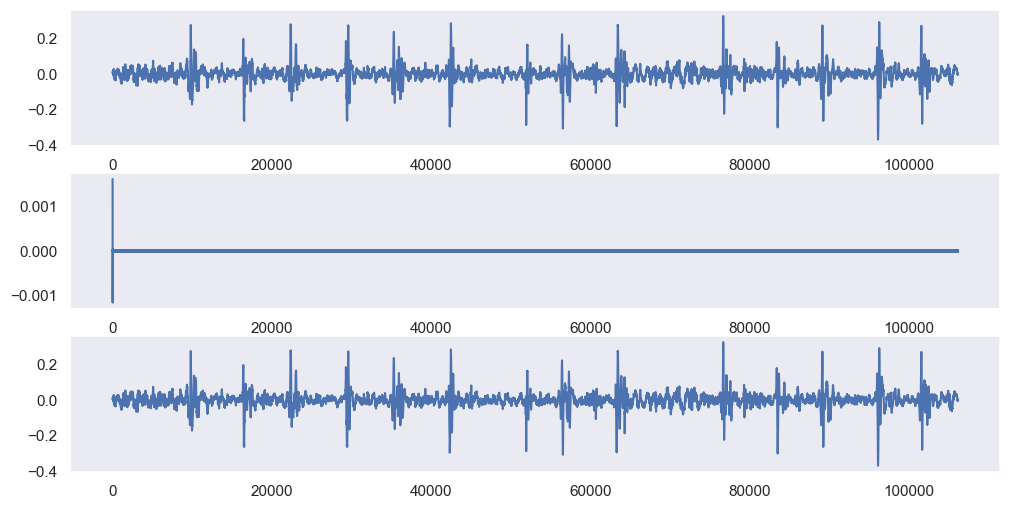

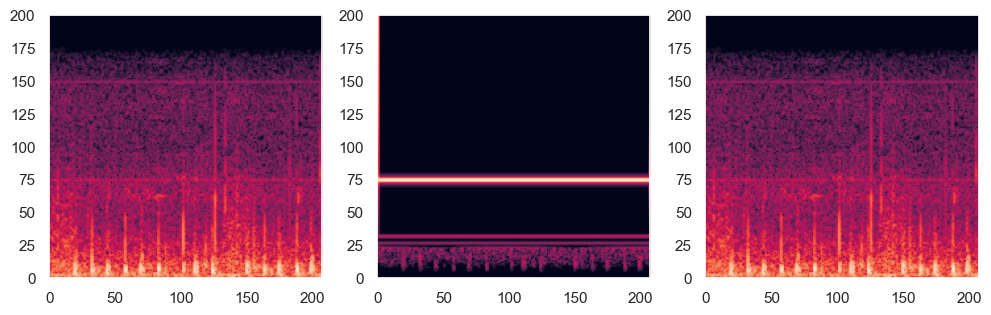

In [65]:
index = 150
noised_data = fft_denoiser(dataset.dataset[index][0], 0.01)
fft = librosa.amplitude_to_db(librosa.stft(dataset.dataset[index][0]))
denoised_fft = librosa.amplitude_to_db(librosa.stft(dataset.dataset[index][0]-noised_data))
noise_fft = librosa.amplitude_to_db(librosa.stft(noised_data))
fig, axes = plt.subplots(3,1,figsize=(12,6))
axes[0].plot(dataset.dataset[index][0])
axes[1].plot(noised_data)
axes[2].plot(dataset.dataset[index][0]-noised_data)

plt.show()
fig, axes = plt.subplots(1,3,figsize=(12,6))
axes[0].imshow(fft)
axes[0].set_ylim([0,200])
axes[1].imshow(noise_fft)
axes[1].set_ylim([0,200])
axes[2].imshow(denoised_fft)
axes[2].set_ylim([0,200])
plt.show()

In [46]:
dataset.fft[100].shape

(1025, 319)

[  1  59 102 149]


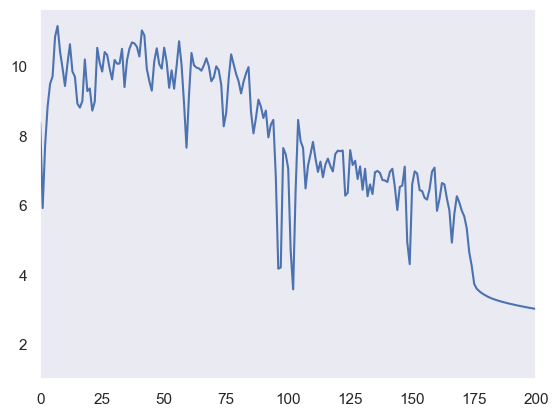

In [16]:
fft_stdev = np.std(dataset.fft[100], axis=1)
plt.plot(fft_stdev)
plt.xlim([0, 200])
peak_array, _ = scipy.signal.find_peaks(-fft_stdev, 
                            distance=30)
for eachvalley in peak_array:
    axes[1].axvline(x = eachvalley/dataset.dataset[index][1], color = 'r', 
                    ls=":", linewidth=0.7)
print(peak_array)

In [17]:
for f_peak in peak_array:
    print(f_peak)

1
59
102
149


In [ ]:
import math
noise_data = dataset.dataset[100][0] + \
    np.sin(np.arange(len(dataset.dataset[100][0]))/dataset.dataset[100][1] / 180 * math.pi * 70000)
    
plt.plot(denoised_data)
plt.show()
denoised_data = dataset.dataset[100][0] - noise_data

denoised_fft = librosa.amplitude_to_db(librosa.stft(denoised_data))
fig, axes = plt.subplots(1,2,figsize=(12,6))

axes[0].imshow(denoised_fft)
axes[0].set_ylim([0,200])

axes[1].imshow(dataset.fft[100])
axes[1].set_ylim([0,200])

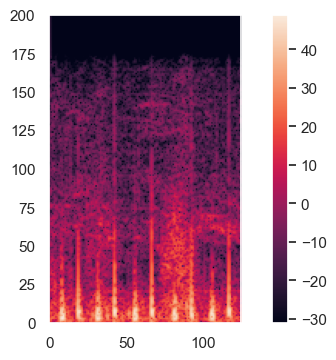

In [69]:
fig = plt.figure(figsize=(8,4))
plt.imshow(dataset.fft[100])
plt.ylim([0,200])
plt.colorbar()

In [7]:
dataset.metadata

,dataset,fname,label,sublabel,bpm,peak-interval,peak-interval-timer
0,b,set_b/extrastole__127_1306764300147_C2.wav,extrastole,NaN,96.235913,"[0.2686167800453515, 0.352562358276644, 0.2744...","[0.1781859410430839, 0.4468027210884354, 0.799..."
1,b,set_b/extrastole__128_1306344005749_A.wav,extrastole,NaN,90.943461,"[0.2494331065759637, 0.37750566893424037, 0.25...","[0.2770068027210884, 0.5264399092970522, 0.903..."
2,b,set_b/extrastole__130_1306347376079_D.wav,extrastole,NaN,112.422248,"[0.2529251700680272, 0.26702947845804986, 0.25...","[0.15156462585034014, 0.40448979591836737, 0.6..."
3,b,set_b/extrastole__134_1306428161797_C1.wav,extrastole,NaN,105.416460,"[0.3017233560090703, 0.28122448979591835, 0.30...","[0.07968253968253969, 0.38140589569161, 0.6626..."
4,b,set_b/extrastole__138_1306762146980_B.wav,extrastole,NaN,74.039667,"[0.28834467120181406, 0.3871201814058957, 0.29...","[0.3514285714285714, 0.6397732426303855, 1.026..."
...,...,...,...,...,...,...,...
456,b,set_b/normal_noisynormal_284_1311168471850_A.wav,normal,noisynormal,96.614187,"[0.3818140589569161, 0.26099773242630386, 0.53...","[0.1110204081632653, 0.4928344671201814, 0.753..."
457,b,set_b/normal_noisynormal_284_1311168471850_B.wav,normal,noisynormal,99.657263,"[0.34607709750566895, 0.2582312925170068, 0.36...","[0.14331065759637188, 0.4893877551020408, 0.74..."
458,b,set_b/normal_noisynormal_285_1311169246969_C.wav,normal,noisynormal,68.588638,"[0.29931972789115646, 0.5092517006802721, 0.29...","[0.2965532879818594, 0.5958730158730159, 1.105..."
459,b,set_b/normal_noisynormal_296_1311682952647_C.wav,normal,noisynormal,118.700977,"[0.28086167800453515, 0.26988662131519275, 0.3...","[0.22136054421768708, 0.5022222222222222, 0.77..."


### 2. Beat per minute distribution across different class

Beat per minute is calculated in function ```aproximate_bpm``` in ```utils.dataset```. 
###### The beats (peaks) are detected using ```scipy.signal.find_peaks```

Text(0.5, 0.98, 'Distribution of Beat Per Minute (BPM) for each class')

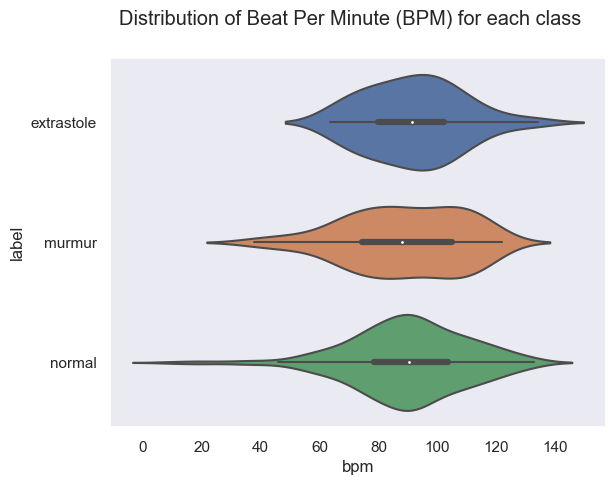

In [25]:
sb.violinplot(data=dataset.metadata, x="bpm", y="label")
plt.plot()
plt.suptitle('Distribution of Beat Per Minute (BPM) for each class')

All 3 class have similar distribution in BPM. Hence, BPM alone may not be a good predictor for classify each heart desease.

## 3. Heart rate variability

In [1]:
fig, axes = plt.subplots(5,5, figsize=(15, 15))
fig.tight_layout(w_pad=3.0)
fig.suptitle('Plot of HRV')
sb.set_theme(style="dark")
plt.subplots_adjust(top=0.95)
for i in range(25):
    loop = 0
    index = np.random.randint(len(dataset)-1)
    label = dataset.metadata['label'][index]
    axes[i//5, i%5].plot(dataset.metadata['peak-interval-timer'][index], dataset.metadata['peak-interval'][index])
    axes[i//5, i%5].set_title(f'{label}')

NameError: name 'plt' is not defined

Feed the model with HRV

In [4]:

PROJECT_DIR = '/Users/nattapolchanpaisit/Documents/GitHub/Algorithm/SC1015-PROJECT/'
dataset = set_b_dataset(PROJECT_DIR)

for index in range(3):
    print(dataset.metadata['label'][index])
    print(dataset.metadata['peak-interval'][index])
    print(len(dataset.metadata['peak-interval'][index]))

extrastole
[0.2686167800453515, 0.352562358276644, 0.2744671201814059, 0.40852607709750566, 0.23392290249433106, 0.3581859410430839, 0.26285714285714284, 0.36317460317460315, 0.27138321995464854, 0.3721541950113379, 0.27111111111111114, 0.4125170068027211, 0.2364172335600907, 0.3891609977324263]
14
extrastole
[0.2494331065759637, 0.37750566893424037, 0.25900226757369615, 0.35306122448979593, 0.2582766439909297, 0.4653514739229025, 0.2564172335600907, 0.361859410430839, 0.2630839002267574, 0.33687074829931973, 0.25927437641723355, 0.3889795918367347, 0.2592290249433107, 0.24462585034013606, 0.21555555555555556, 0.2592290249433107, 0.3946031746031746, 0.2638095238095238, 0.3851700680272109, 0.26108843537414966, 0.5020861678004536, 0.5346031746031746, 0.26467120181405895, 0.36108843537414964, 0.26312925170068024, 0.423265306122449, 0.2452607709750567]
27
extrastole
[0.2529251700680272, 0.26702947845804986, 0.25523809523809526, 0.26335600907029477, 0.2472108843537415, 0.265578231292517, 0.